In [360]:
import os

import datetime

import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from scipy.stats import norm

import matplotlib.pyplot as plt

# Data Import

In [361]:
path_in='C:/Users/dkoch/Documents/Python Scripts/Booking Curves/Data'
path_out=path_in

In [362]:
Forecast=pd.read_csv(path_in+'/Query Data/R_Output.csv',sep=',')

# Model error computation

In [363]:
Forecast['error']=(Forecast['NumPax']-Forecast['forecast'])**2
Forecast['se_oos']=np.sqrt(Forecast.groupby(['dday','dtime','Direction','month','Dprio'])['error'].transform('mean'))
Forecast['error']=np.sqrt(Forecast['error'])

# Compute booking curves

In [364]:
Forecast['Dprio']=-Forecast['Dprio']

########################################################

Forecast=Forecast.set_index(['DepDate','Dprio','dday','dtime','Direction','month','yday'])
Forecast_Cum=Forecast.groupby(level=[0,1,2,3,4,5,6]).sum().groupby(level=[0,2,3,4,5,6])['forecast'].cumsum().reset_index()

########################################################

Forecast['se_oos']=Forecast['se_oos']**2
Se_Cum=Forecast.groupby(level=[0,1,2,3,4,5,6]).sum().groupby(level=[0,2,3,4,5,6])['se_oos'].cumsum().reset_index()
Se_Cum['se_oos']=np.sqrt(Se_Cum['se_oos'])
Forecast_Cum=Forecast_Cum.merge(Se_Cum,on=['DepDate','Dprio','dday','dtime','Direction','month','yday'])

########################################################

Obs_Cum=Forecast.groupby(level=[0,1,2,3,4,5,6]).sum().groupby(level=[0,2,3,4,5,6])['NumPax'].cumsum().reset_index()
Forecast_Cum=Forecast_Cum.merge(Obs_Cum,on=['DepDate','Dprio','dday','dtime','Direction','month','yday'])

########################################################

Forecast_Cum['Dprio']=-Forecast_Cum['Dprio']

# Change time format

In [365]:
deptime=[str(x/60).split('.')[0]+':'+str(round(float('0.'+str(x/60).split('.')[1])*60)) for x in Forecast_Cum['dtime'].unique()]

Map_DepTime=DataFrame([Forecast_Cum['dtime'].unique(),[x+'0' if len(x.split(':')[1])==1 else x for x in deptime]]).transpose()
Map_DepTime.columns=['dtime','deptime']

Forecast_Cum=Forecast_Cum.merge(Map_DepTime,on='dtime')

Forecast_Cum['dtime']=Forecast_Cum['deptime']
Forecast_Cum=Forecast_Cum[[x for x in Forecast_Cum.columns if x!='deptime']]

In [366]:
Threshold_FlightLevel=Forecast_Cum.copy()

Threshold_FlightLevel['n']=Threshold_FlightLevel.groupby(['DepDate','dday','dtime','Direction','month','yday'])['Dprio'].transform('size')

alpha=0.01
alpha=alpha/2

Threshold_FlightLevel['alpha']=alpha/Threshold_FlightLevel['n']

Map_AlphaAndMult=DataFrame([Threshold_FlightLevel['alpha'].unique().tolist(),
[abs(norm.ppf(x)) for x in Threshold_FlightLevel['alpha'].unique().tolist()]]).transpose()
Map_AlphaAndMult.columns=['alpha','mult']

Threshold_FlightLevel=Threshold_FlightLevel.merge(Map_AlphaAndMult,on='alpha')

Threshold_FlightLevel['mult']=1

Threshold_FlightLevel['PI_lb']=Threshold_FlightLevel['forecast']-(Threshold_FlightLevel['mult']*Threshold_FlightLevel['se_oos'])
Threshold_FlightLevel['PI_ub']=Threshold_FlightLevel['forecast']+(Threshold_FlightLevel['mult']*Threshold_FlightLevel['se_oos'])

# Graphical analysis

2019-02-22


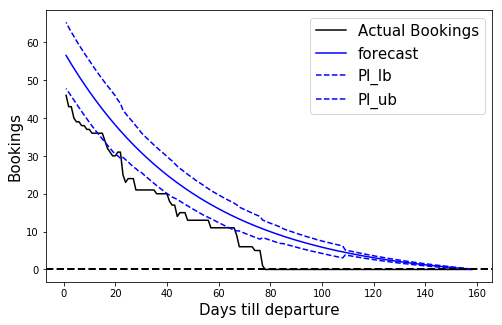

In [367]:
pick_date=Threshold_FlightLevel['DepDate'].unique()[17]

print(pick_date)

plt.figure(1, figsize=(8, 5))

plt.plot(Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'Dprio'],
Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'NumPax'],color='black',
label='Actual Bookings')

plt.plot(Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'Dprio'],
Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'forecast'],color='blue')

plt.plot(Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'Dprio'],
Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'PI_lb'],color='blue',linestyle='--')

plt.plot(Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'Dprio'],
Threshold_FlightLevel.loc[(Threshold_FlightLevel['DepDate']==pick_date)&(Threshold_FlightLevel['Direction']=='O')&(Threshold_FlightLevel['dtime']=='7:45'),'PI_ub'],color='blue',linestyle='--')

plt.axhline(linewidth=2,color='black',linestyle='--')
    
plt.xlabel('Days till departure',size=15)
plt.ylabel('Bookings',size=15)
#plt.suptitle('Booking curves alert system',size=17.5,fontweight='bold',line=1)

plt.legend(prop={'size': 15})

plt.show()

# Case Study: Impact of tactical fares

In [368]:
ForecastAggrStrat=Forecast_Cum.loc[(pd.to_datetime(Forecast_Cum['DepDate'])<=pd.to_datetime('2019-03-31'))\
&((Forecast_Cum['dday'].apply(lambda x: x in ['Monday','Tuesday'])&(Forecast_Cum['dtime']=='7:45'))\
 |(Forecast_Cum['dday'].apply(lambda x: x in ['Thursday','Friday'])&((Forecast_Cum['dtime']=='15:50')\
 |(Forecast_Cum['dtime']=='20:20')))),:].copy()
ForecastAggrStrat=ForecastAggrStrat.groupby('Dprio')[['NumPax','forecast','se_oos']].apply(lambda x: x.sum()).reset_index()
ForecastAggrStrat['PI_lb']=ForecastAggrStrat['forecast']-(2*ForecastAggrStrat['se_oos'])
ForecastAggrStrat['PI_ub']=ForecastAggrStrat['forecast']+(2*ForecastAggrStrat['se_oos'])

######################################################################

ForecastAggrNonStrat=Forecast_Cum.loc[(pd.to_datetime(Forecast_Cum['DepDate'])<=pd.to_datetime('2019-03-31'))\
&((Forecast_Cum['dday'].apply(lambda x: x not in ['Monday','Tuesday'])|(Forecast_Cum['dtime']!='7:45'))\
 &(Forecast_Cum['dday'].apply(lambda x: x not in ['Thursday','Friday'])|((Forecast_Cum['dtime']!='15:50')\
 &(Forecast_Cum['dtime']!='20:20')))),:].copy()

ForecastAggrNonStrat=ForecastAggrNonStrat.groupby('Dprio')[['NumPax','forecast','se_oos']].apply(lambda x: x.sum()).reset_index()
ForecastAggrNonStrat['PI_lb']=ForecastAggrNonStrat['forecast']-(2*ForecastAggrNonStrat['se_oos'])
ForecastAggrNonStrat['PI_ub']=ForecastAggrNonStrat['forecast']+(2*ForecastAggrNonStrat['se_oos'])

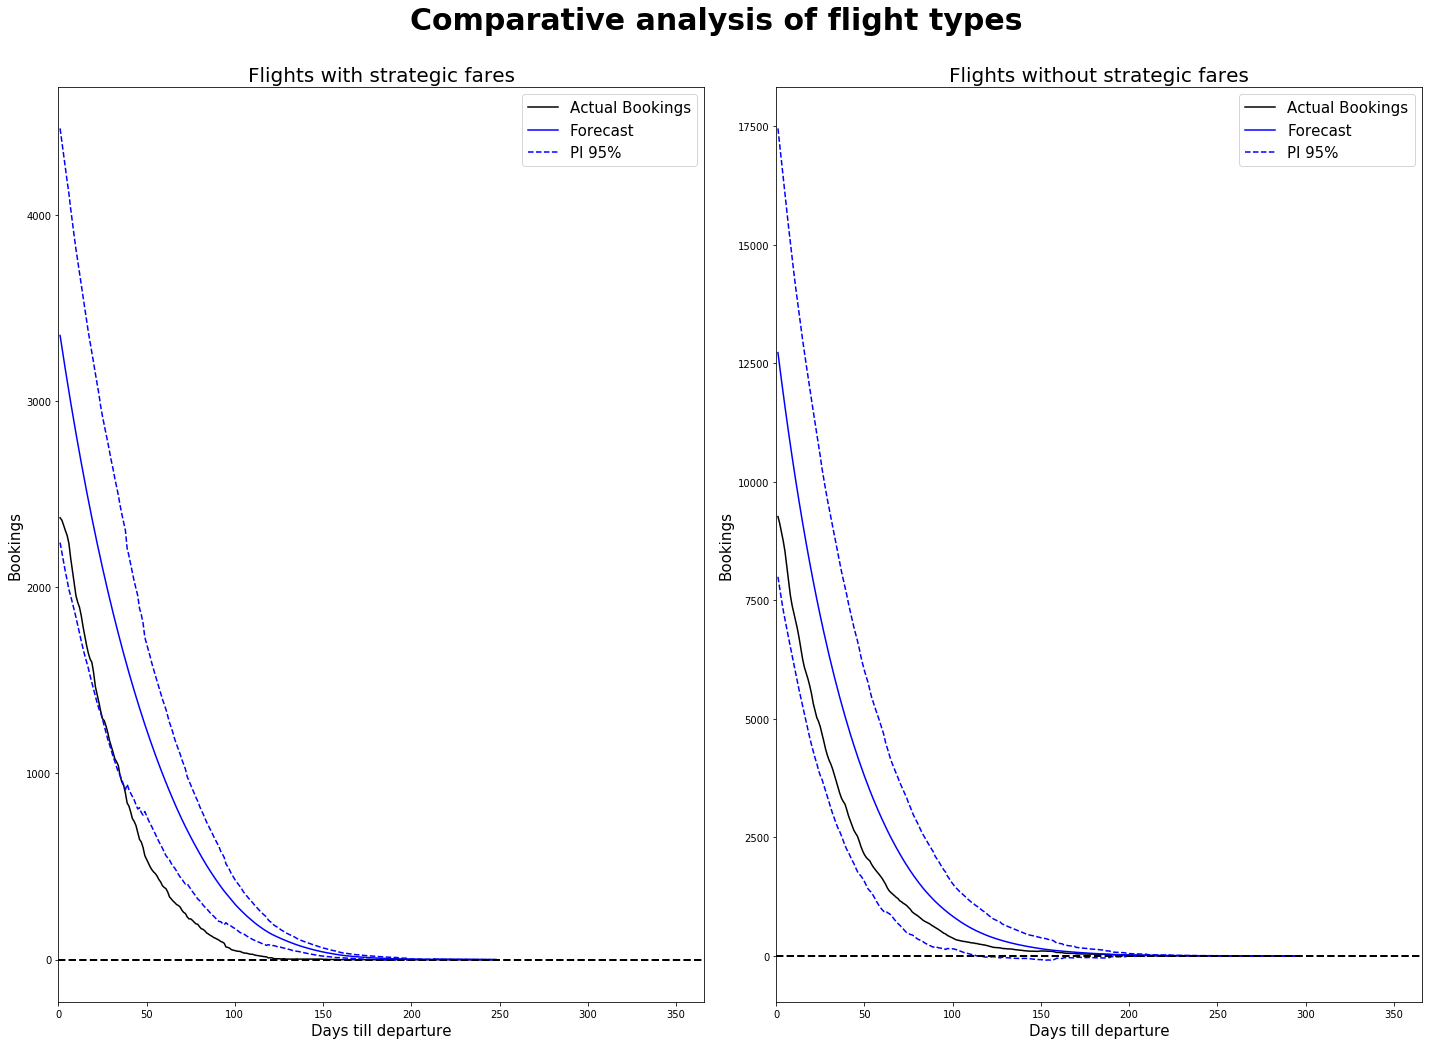

In [369]:
fig=plt.figure(1,figsize=(20,15))

ax=fig.add_subplot(1,2,1)

ax.plot(ForecastAggrStrat['Dprio'],ForecastAggrStrat['NumPax'],color='black',label='Actual Bookings')
ax.plot(ForecastAggrStrat['Dprio'],ForecastAggrStrat['forecast'],color='blue',label='Forecast')
ax.plot(ForecastAggrStrat['Dprio'],ForecastAggrStrat['PI_lb'],color='blue',label='PI 95%',linestyle='--')
ax.plot(ForecastAggrStrat['Dprio'],ForecastAggrStrat['PI_ub'],color='blue',label='',linestyle='--')

ax.axhline(linewidth=2,color='black',linestyle='--')
    
plt.xlabel('Days till departure',size=15)
plt.ylabel('Bookings',size=15)
plt.xlim(0,366)

plt.title('Flights with strategic fares',size=20)

plt.legend(prop={'size': 15})

####################################################

ax=fig.add_subplot(1,2,2)

ax.plot(ForecastAggrNonStrat['Dprio'],ForecastAggrNonStrat['NumPax'],color='black',label='Actual Bookings')
ax.plot(ForecastAggrNonStrat['Dprio'],ForecastAggrNonStrat['forecast'],color='blue',label='Forecast')
ax.plot(ForecastAggrNonStrat['Dprio'],ForecastAggrNonStrat['PI_lb'],color='blue',label='PI 95%',linestyle='--')
plt.plot(ForecastAggrNonStrat['Dprio'],ForecastAggrNonStrat['PI_ub'],color='blue',label='',linestyle='--')

ax.axhline(linewidth=2,color='black',linestyle='--')
    
plt.xlabel('Days till departure',size=15)
plt.ylabel('Bookings',size=15)
plt.xlim(0,366)

plt.title('Flights without strategic fares',size=20)

plt.legend(prop={'size': 15})

plt.suptitle('Comparative analysis of flight types',size=30,fontweight='bold',x=0.5,y=0.995)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(path_out+'/Plot1.png')

In [370]:
ForecastAggrStrat=Forecast_Cum.loc[(pd.to_datetime(Forecast_Cum['DepDate'])<=pd.to_datetime('2019-03-31'))\
&((Forecast_Cum['dday'].apply(lambda x: x in ['Monday','Tuesday'])&(Forecast_Cum['dtime']=='7:45'))\
 |(Forecast_Cum['dday'].apply(lambda x: x in ['Thursday','Friday'])&((Forecast_Cum['dtime']=='15:50')\
 |(Forecast_Cum['dtime']=='20:20')))),:].copy()
ForecastAggrStrat=ForecastAggrStrat.groupby(['dday','Dprio'])[['NumPax','forecast','se_oos']].apply(lambda x: x.sum()).reset_index()
ForecastAggrStrat['PI_lb']=ForecastAggrStrat['forecast']-(2*ForecastAggrStrat['se_oos'])
ForecastAggrStrat['PI_ub']=ForecastAggrStrat['forecast']+(2*ForecastAggrStrat['se_oos'])

######################################################################

ForecastAggrNonStrat=Forecast_Cum.loc[(pd.to_datetime(Forecast_Cum['DepDate'])<=pd.to_datetime('2019-03-31'))\
&((Forecast_Cum['dday'].apply(lambda x: x not in ['Monday','Tuesday'])|(Forecast_Cum['dtime']!='7:45'))\
 &(Forecast_Cum['dday'].apply(lambda x: x not in ['Thursday','Friday'])|((Forecast_Cum['dtime']!='15:50')\
 &(Forecast_Cum['dtime']!='20:20')))),:].copy()

ForecastAggrNonStrat=ForecastAggrNonStrat.groupby(['dday','Dprio'])[['NumPax','forecast','se_oos']].apply(lambda x: x.sum()).reset_index()
ForecastAggrNonStrat['PI_lb']=ForecastAggrNonStrat['forecast']-(2*ForecastAggrNonStrat['se_oos'])
ForecastAggrNonStrat['PI_ub']=ForecastAggrNonStrat['forecast']+(2*ForecastAggrNonStrat['se_oos'])

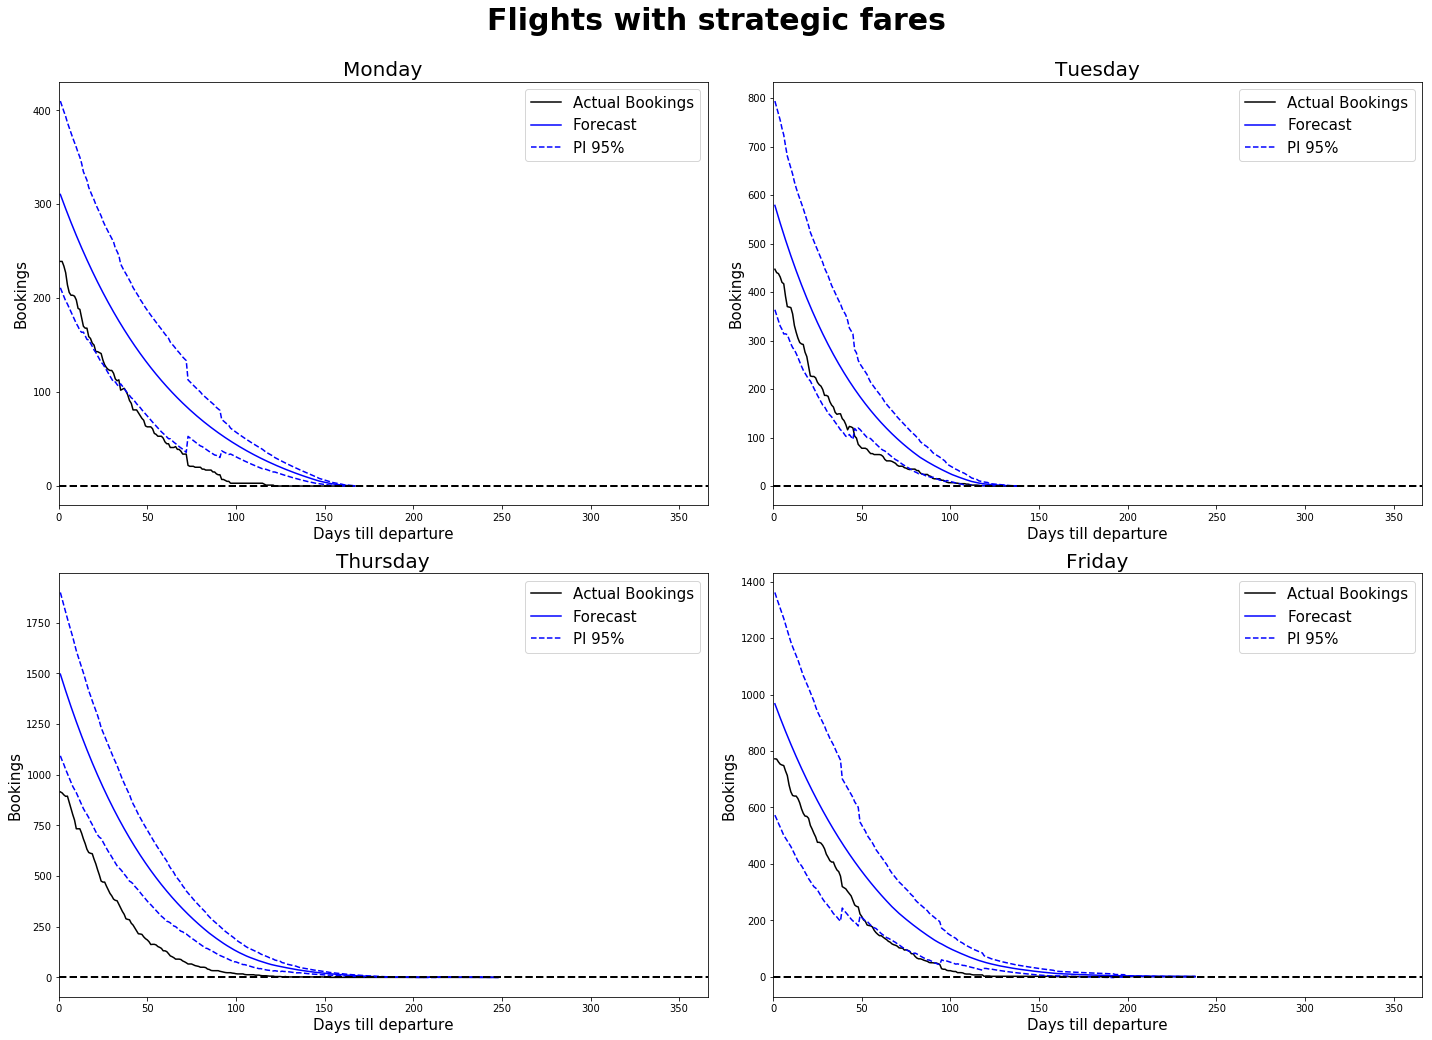

In [371]:
dday_list=['Monday','Tuesday','Thursday','Friday']

fig=plt.figure(1,figsize=(20,15))

for i in range(len(dday_list)):

    dday_pick=dday_list[i]    

    ax=fig.add_subplot(2,2,i+1)
    plt.subplots_adjust(bottom=-0.05)
    
    ax.plot(ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'Dprio'],
    ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'NumPax'],color='black',label='Actual Bookings')
    ax.plot(ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'Dprio'],
    ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'forecast'],color='blue',label='Forecast')
    ax.plot(ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'Dprio'],
    ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'PI_lb'],color='blue',label='PI 95%',linestyle='--')
    plt.plot(ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'Dprio'],
    ForecastAggrStrat.loc[ForecastAggrStrat['dday']==dday_pick,'PI_ub'],color='blue',label='',linestyle='--')

    ax.axhline(linewidth=2,color='black',linestyle='--')

    plt.xlabel('Days till departure',size=15)
    plt.ylabel('Bookings',size=15)
    plt.xlim(0,366)

    plt.title(dday_list[i],size=20)

    plt.legend(prop={'size': 15})

    plt.suptitle('Flights with strategic fares',size=30,fontweight='bold',x=0.5,y=0.99)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])    
plt.savefig(path_out+'/Plot2.png')